# Credit Card Analysis and Fraud Detection

##### We need to import some libraries and create the engine to connect with the DB

In [150]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import warnings
warnings.filterwarnings('ignore')

driver = 'mysql+pymysql:'
user = 'root'
password = ''
ip = '127.0.0.1'
db = 'Final_project'
connection_string = f'{driver}//{user}:{password}@{ip}/{db}'

Creating a function that print confusion matrix and classification report based in a model

In [120]:
def result(model):
    """
    We created this function to clean the data and have a better code.
    arg: Pandas Dataframe

    """
    y_pred = model.predict(X_test)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

Importing information from the DB

In [66]:
query = """SELECT Transaction_base.credit_card_id, Transaction_base.Transaction_Date, 
Transaction_base.Transaction_Value, Card_base.Card_Family, Card_base.Credit_limit, Customer_base.Age, 
Transaction_base.Transaction_ID, Transaction_base.Transaction_Segment, IFNULL(Fraud_base.Fraud_Flag,0) as Fraud_flag
FROM Transaction_base 
LEFT JOIN Fraud_base
ON Transaction_base.Transaction_ID = Fraud_base.Transaction_ID
LEFT JOIN Card_base
ON Transaction_base.Credit_Card_ID = Card_base.Card_Number
LEFT JOIN Customer_base
ON Card_base.Cust_ID = Customer_base.Cust_ID;"""
engine = create_engine(connection_string)

In [86]:
transaction_df = pd.read_sql(query, engine)

In [87]:
transaction_df_original = transaction_df.copy()

In [88]:
transaction_df.head()

,credit_card_id,Transaction_Date,Transaction_Value,Card_Family,Credit_limit,Age,Transaction_ID,Transaction_Segment,Fraud_flag
0,1629-9566-3285-2123,2016-04-24,23649.0,Platinum,194000,23,CTID28830551,SEG25,0
1,3697-6001-4909-5350,2016-02-11,26726.0,Gold,15000,48,CTID45504917,SEG16,0
2,5864-4475-3659-1440,2016-11-01,22012.0,Gold,2000,23,CTID47312290,SEG14,0
3,5991-4421-8476-3804,2016-01-28,37637.0,Gold,19000,44,CTID25637718,SEG17,0
4,1893-8853-9900-8478,2016-03-17,5113.0,Premium,417000,42,CTID66743960,SEG14,0


In [89]:
transaction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
credit_card_id         10000 non-null object
Transaction_Date       10000 non-null object
Transaction_Value      10000 non-null float64
Card_Family            10000 non-null object
Credit_limit           10000 non-null int64
Age                    10000 non-null int64
Transaction_ID         10000 non-null object
Transaction_Segment    10000 non-null object
Fraud_flag             10000 non-null int64
dtypes: float64(1), int64(3), object(5)
memory usage: 703.2+ KB


We check if the fraud_flag column is imbalanced (Yes, it is!)

In [90]:
transaction_df['Fraud_flag'].value_counts()

0    9891
1     109
Name: Fraud_flag, dtype: int64

In [91]:
transaction_df['Fraud_flag'].value_counts()[1]/transaction_df['Fraud_flag'].value_counts()[0]*100

1.1020119300374078

In [92]:
transaction_df.Transaction_Date = pd.to_datetime(transaction_df['Transaction_Date'], yearfirst = True)

In [93]:
transaction_df['Transaction_Date'] = pd.to_numeric(transaction_df['Transaction_Date'])

In [94]:
X = transaction_df.drop(columns = ['credit_card_id', 'Transaction_ID', 'Transaction_Segment'])

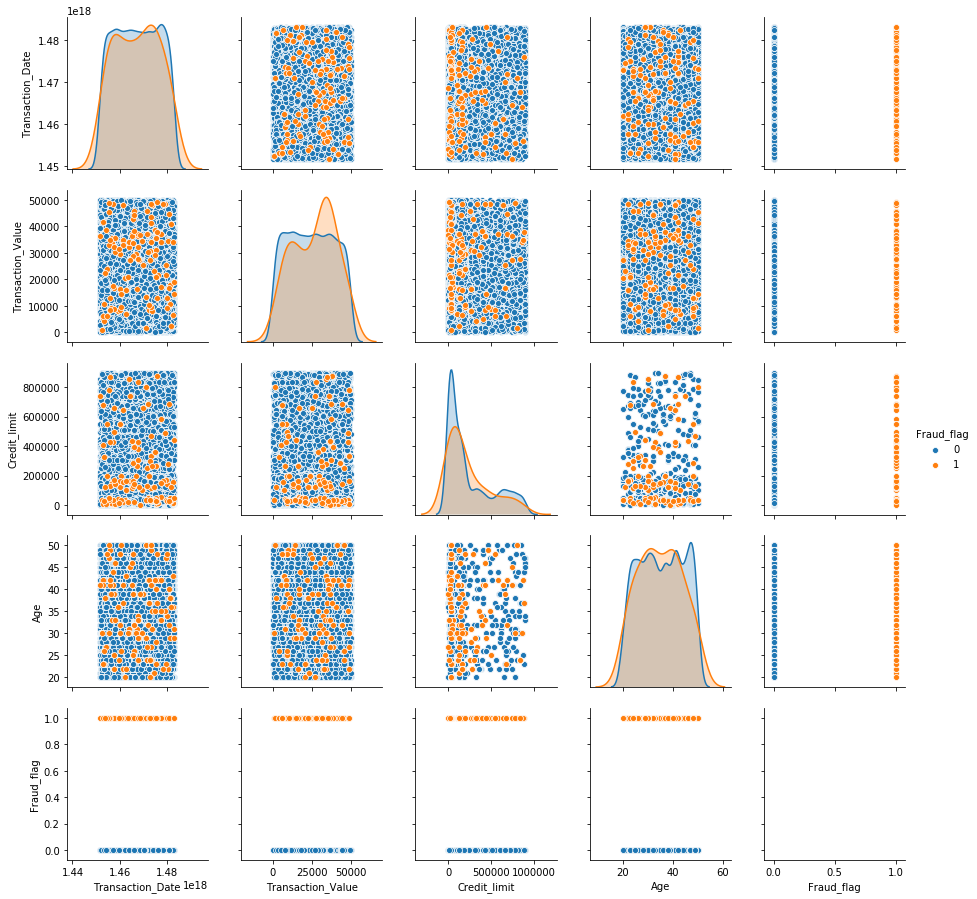

In [98]:
sns.pairplot(transaction_df, hue = 'Fraud_flag')

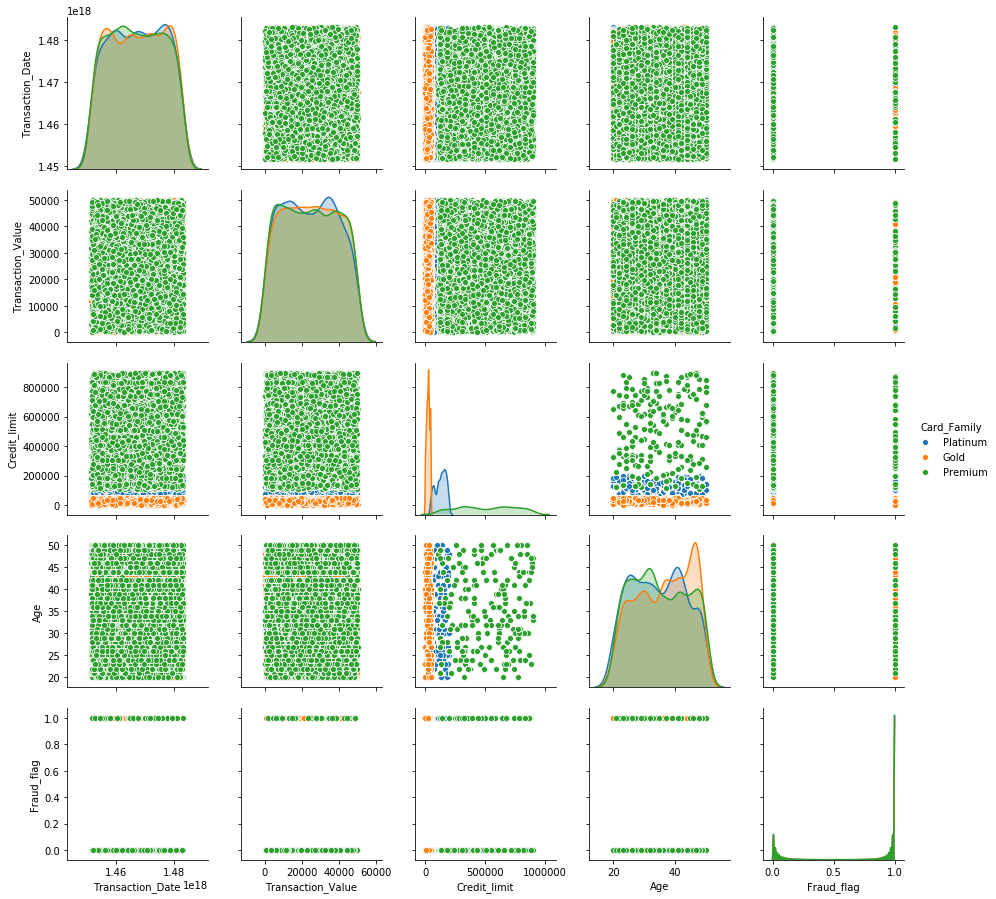

In [99]:
sns.pairplot(transaction_df, hue = 'Card_Family')

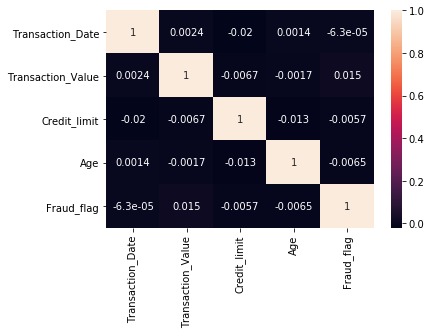

In [112]:
sns.heatmap(transaction_df.corr(), annot = True)

In [95]:
y = X.pop('Fraud_flag')

In [96]:
X = pd.get_dummies(X, drop_first = True)

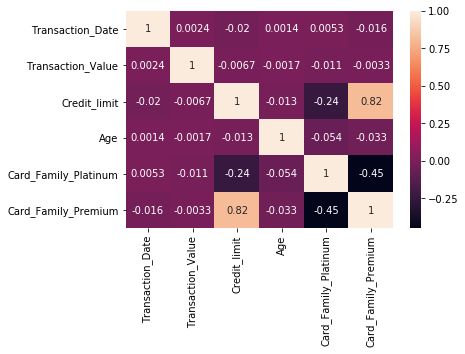

In [114]:
sns.heatmap(X.corr(), annot = True)

# We have so many differences in the units so we need to scale

In [80]:
from sklearn.preprocessing import scale
X = scale(X)

# To fight against imbalance classes we need to use some techniques, the first one we are going to use is Synthetic Minority Over-sampling Technique (SMOTE)

To illustrate how this technique works consider some training data which has s samples, and f features in the feature space of the data. Note that these features, for simplicity, are continuous. As an example, consider a dataset of birds for classification. The feature space for the minority class for which we want to oversample could be beak length, wingspan, and weight (all continuous). To then oversample, take a sample from the dataset, and consider its k nearest neighbors (in feature space). To create a synthetic data point, take the vector between one of those k neighbors, and the current data point. Multiply this vector by a random number x which lies between 0, and 1. Add this to the current data point to create the new, synthetic data point. Source: https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis#SMOTE

In [100]:
from imblearn import over_sampling
from collections import Counter

In [101]:
resample = over_sampling.SMOTE(random_state = 12)

In [102]:
x_res, y_res = resample.fit_resample(X,y)

In [103]:
Counter(y_res)

Counter({0: 9891, 1: 9891})

In [105]:
len(x_res)

19782

Before importing the models let's do the train-test split of the data

In [126]:
from sklearn.model_selection import train_test_split, cross_val_score
X_train, X_test, y_train, y_test = train_test_split(x_res, y_res, test_size=0.2, random_state=12)

# Now we have to select some machine learning models

In [110]:
from sklearn.metrics import confusion_matrix, classification_report
#We import some metrics to compare our models

### Watching the scikit-learn cheat sheet, we need to select the K Nearest Neighbors (KNN), so let's import the model and train it!

Neighbors-based classification is a type of instance-based learning or non-generalizing learning: it does not attempt to construct a general internal model, but simply stores instances of the training data. Classification is computed from a simple majority vote of the nearest neighbors of each point: a query point is assigned the data class which has the most representatives within the nearest neighbors of the point. Source: https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-classification

In [127]:
%time
from sklearn.neighbors import KNeighborsClassifier
KNN_model = KNeighborsClassifier(n_neighbors = 5 , weights = 'uniform', n_jobs = -1, )
KNN_model.fit(X_train, y_train)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.87 µs


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform')

In [128]:
result(KNN_model)

[[1978   30]
 [ 284 1665]]
              precision    recall  f1-score   support

           0       0.87      0.99      0.93      2008
           1       0.98      0.85      0.91      1949

   micro avg       0.92      0.92      0.92      3957
   macro avg       0.93      0.92      0.92      3957
weighted avg       0.93      0.92      0.92      3957



Explanation of the confusion matrix, bla bla bla

### Now let's try the RandomForestClassifier

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True (default). Source: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [129]:
%time
from sklearn.ensemble import RandomForestClassifier
RFC_model = RandomForestClassifier(max_depth = 12, n_jobs = -1, random_state = 12)
RFC_model.fit(X_train, y_train)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.15 µs


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=12, verbose=0, warm_start=False)

In [130]:
result(RFC_model)

[[1970   38]
 [ 102 1847]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      2008
           1       0.98      0.95      0.96      1949

   micro avg       0.96      0.96      0.96      3957
   macro avg       0.97      0.96      0.96      3957
weighted avg       0.97      0.96      0.96      3957



# Now let's try the XGBoost

XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. Source: https://xgboost.readthedocs.io/en/latest/

In [131]:
%time
from xgboost import XGBClassifier
XGB_model = XGBClassifier(max_depth = 12,seed = 12)
XGB_model.fit(X_train, y_train)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.87 µs


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=12, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=12, silent=True,
       subsample=1)

In [135]:
cross_val_score(XGB_model, X, y, cv = 5)

array([0.9890055 , 0.989     , 0.989     , 0.989     , 0.98949475])

In [132]:
result(XGB_model)

[[1995   13]
 [  26 1923]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2008
           1       0.99      0.99      0.99      1949

   micro avg       0.99      0.99      0.99      3957
   macro avg       0.99      0.99      0.99      3957
weighted avg       0.99      0.99      0.99      3957



# We want to check if there's seasonality 

In [136]:
import statsmodels.api as sm

In [137]:
timeseries_df = transaction_df_original.copy()

In [138]:
timeseries_df.Transaction_Date = pd.to_datetime(timeseries_df['Transaction_Date'], yearfirst = True)

In [142]:
timeseries_df = timeseries_df.set_index('Transaction_Date')

In [187]:
y_time = timeseries_df['Fraud_flag'].resample('d').sum()

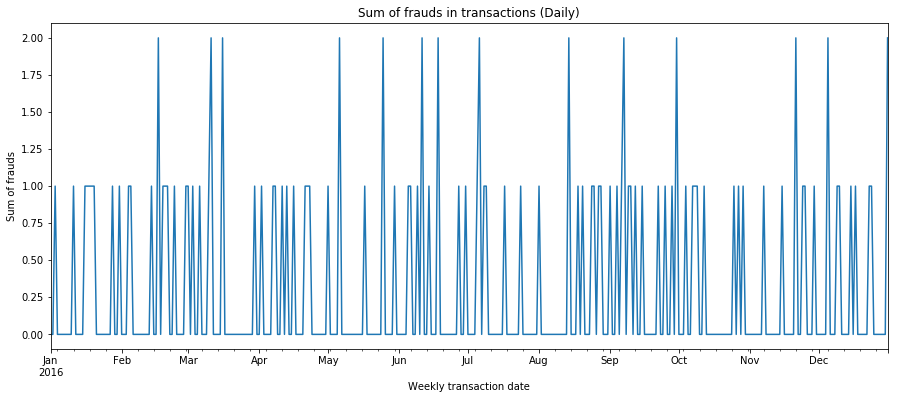

In [188]:
y_time.plot(figsize=(15, 6))
plt.ylabel('Sum of frauds')
plt.xlabel('Weekly transaction date')
plt.title('Sum of frauds in transactions (Daily)')
plt.show()

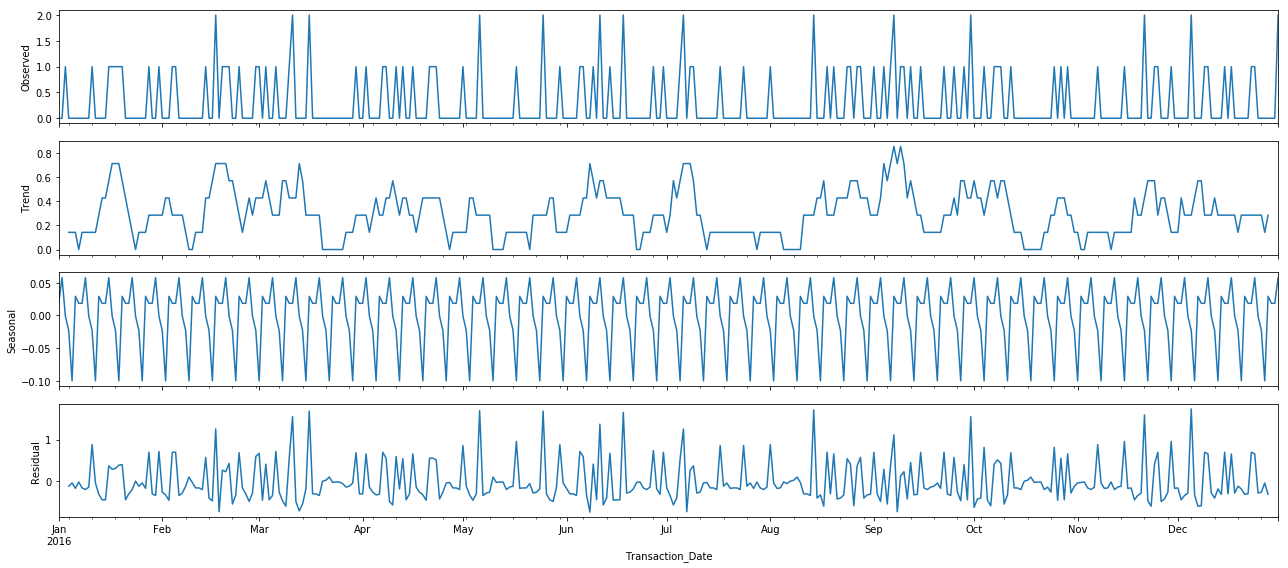

In [189]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y_time, model = 'additive')
fig = decomposition.plot()
plt.show()